##Intro to Programming Project: Protein TAG Variant Screen

In [1]:
#@title Install dependencies
%%bash -s $use_amber $use_templates

set -e

USE_AMBER=$1
USE_TEMPLATES=$2

if [ ! -f COLABFOLD_READY ]; then
  # install dependencies
  # We have to use "--no-warn-conflicts" because colab already has a lot preinstalled with requirements different to ours
  pip install -q --no-warn-conflicts "colabfold[alphafold-minus-jax] @ git+https://github.com/sokrypton/ColabFold"
  # high risk high gain
  pip install -q "jax[cuda11_cudnn805]>=0.3.8,<0.4" -f https://storage.googleapis.com/jax-releases/jax_releases.html
  touch COLABFOLD_READY
fi

# setup conda
if [ ${USE_AMBER} == "True" ] || [ ${USE_TEMPLATES} == "True" ]; then
  if [ ! -f CONDA_READY ]; then
    wget -qnc https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
    bash Miniconda3-latest-Linux-x86_64.sh -bfp /usr/local 2>&1 1>/dev/null
    rm Miniconda3-latest-Linux-x86_64.sh
    touch CONDA_READY
  fi
fi
# setup template search
if [ ${USE_TEMPLATES} == "True" ] && [ ! -f HH_READY ]; then
  conda install -y -q -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 python=3.7 2>&1 1>/dev/null
  touch HH_READY
fi
# setup openmm for amber refinement
if [ ${USE_AMBER} == "True" ] && [ ! -f AMBER_READY ]; then
  conda install -y -q -c conda-forge openmm=7.5.1 python=3.7 pdbfixer 2>&1 1>/dev/null
  touch AMBER_READY
fi

In [3]:
#Loading all necessary modules/packages
#Input protein sequence(s)
from google.colab import files
import os.path
from os import path
import re
import hashlib
import random

#Run Prediction
import sys
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#User Iterface
import sys
!{sys.executable} -m pip install gradio
import gradio  as gr

#RMSD Calculations
!{sys.executable} -m pip install Bio
!{sys.executable} -m pip install rmsd
import Bio
from Bio import PDB
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import shutil

from colabfold.download import download_alphafold_params, default_data_dir
from colabfold.utils import setup_logging
from colabfold.batch import get_queries, run, set_model_type
K80_chk = !nvidia-smi | grep "Tesla K80" | wc -l
if "1" in K80_chk:
  print("WARNING: found GPU Tesla K80: limited to total length < 1000")
  if "TF_FORCE_UNIFIED_MEMORY" in os.environ:
    del os.environ["TF_FORCE_UNIFIED_MEMORY"]
  if "XLA_PYTHON_CLIENT_MEM_FRACTION" in os.environ:
    del os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]

from colabfold.colabfold import plot_protein
from pathlib import Path
import matplotlib.pyplot as plt

#Creates the directory path where the created PDB files are stored (if it doesnt exist already)
if(not (os.path.isdir("PDBs"))):
  os.mkdir("PDBs")

if(not (os.path.isdir("aligned"))):
  os.mkdir("aligned")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
#Functional approach to iterating over given dictionary of values

#Dictionary for TAG sequences
tag_sequences = {"6X His":"HHHHHH", "CBP":"KRRWKKNFIAVSAANRFKKISSSGAL",
                     "CBD + 3G": "GGGTNPGVSAWQVNTAYTAGQLVTYNGKTYKCLQPHTSLAGWEPSNVPALWQLQ",
                     "mNEONGreen + 5G": "GGGGGMVSKGEEDNMASLPATHELHIFGSINGVDFDMVGQGTGNPNDGYEELNLKSTKGDLQFSPWILVPHIGYGFHQYLPYPDGMSPFQAAMVDGSGYQVHRTMQFEDGASLTVNYRYTYEGSHIKGEAQVKGTGFPADGPVMTNSLTAADWCRSKKTYPNDKTIISTFKWSYTTGNGKRYRSTARTTYTFAKPMAANYLKNQPMYVFRKTELKHSKTELNFKEWQKAFTDVMGMDELYK"
                     }

#Hash function for producing keys for appending to jobname
def add_hash(x,y):
  return x+"_"+hashlib.sha1(y.encode()).hexdigest()[:5]

#Takes a dictionary of values and builds an array of all the filepaths
def input_dict(variant_dict,isAdd):
  #Clears PDBs files for analysis, so that new inputs can added
  PDB_dir = "/content/PDBs/"
  if (isAdd):
    for PDB in os.listdir(PDB_dir):
      os.remove(os.path.join(PDB_dir,PDB))

  paths_dict = {}
  for name in variant_dict:
    # Initialization of the query_sequence
    # Removes whitespaces
    query_sequence = variant_dict[name]
    query_sequence = "".join(query_sequence.split())
    # Initialization of the jobname
    # Removes whitespaces and append hash key
    jobname = name
    basejobname = "".join(jobname.split())
    basejobname = re.sub(r'\W+', '', basejobname)
    jobname = add_hash(basejobname, query_sequence)
    while os.path.isfile(f"{jobname}.csv"):
      jobname = add_hash(basejobname, ''.join(random.sample(query_sequence,len(query_sequence))))

    with open(f"{jobname}.csv", "w") as text_file:
      text_file.write(f"id,sequence\n{jobname},{query_sequence}")

    #local variables needed to run prediction (most of these are adjustable, but for our purposes we are running them as default)
    #MS
    queries_path=f"{jobname}.csv"
    use_amber = False
    template_mode = "none"
    custom_template_path = None
    use_templates = False
    msa_mode = "MMseqs2 (UniRef+Environmental)"
    pair_mode = "unpaired+paired"
    a3m_file = f"{jobname}.a3m"
    model_type = "auto"
    num_recycles = 3
    save_to_google_drive = False
    dpi = 200

    input_array = [queries_path,use_amber,template_mode,custom_template_path,use_templates,msa_mode,pair_mode,a3m_file,model_type,num_recycles,save_to_google_drive,dpi]

    if use_amber and '/usr/local/lib/python3.7/site-packages/' not in sys.path:
      sys.path.insert(0, '/usr/local/lib/python3.7/site-packages/')

    jobname_path = run_prediction(jobname,input_array,"PDBs")
    paths_dict[name] = jobname_path

  #Deletes all files stored in the sample data (to clear room for subsequent runs)
  delete_dir = "/content/"
  for file in os.listdir(delete_dir):
    if(path.isfile(file)):
      os.remove(os.path.join(delete_dir,file))

  return paths_dict

def prediction_callback(unrelaxed_protein, length, prediction_result, input_features, type):
  fig = plot_protein(unrelaxed_protein, Ls=length, dpi=150)
  plt.show()
  plt.close()

#Runs a prediction and moves the resulting rank 1 pdb structure (model does not matter) into a desired directory
#Must provide the data array (contains all the parameters to run prediction) and directory path. 
#Returns the filepath of the PDB structure ofr the variant
def run_prediction(jobname,data_array,directory_name):
  #
  result_dir="."
  if 'logging_setup' not in globals():
      setup_logging(Path(".").joinpath("log.txt"))
      logging_setup = True
  
  queries_path=data_array[0]
  use_amber = data_array[1]
  template_mode = data_array[2]
  custom_template_path = data_array[3]
  use_templates = data_array[4]
  msa_mode = data_array[5]
  pair_mode = data_array[6]
  a3m_file = data_array[7]
  model_type = data_array[8]
  num_recycles = data_array[9]
  save_to_google_drive = data_array[10]
  dpi = data_array[11]
  
  queries, is_complex = get_queries(queries_path)
  model_type = set_model_type(is_complex, model_type)
  download_alphafold_params(model_type, Path("."))
  run(
      queries=queries,
      result_dir=result_dir,
      use_templates=use_templates,
      custom_template_path=custom_template_path,
      use_amber=use_amber,
      msa_mode=msa_mode,    
      model_type=model_type,
      num_models=5,
      num_recycles=num_recycles,
      model_order=[1, 2, 3, 4, 5],
      is_complex=is_complex,
      data_dir=Path("."),
      keep_existing_results=False,
      recompile_padding=1.0,
      rank_by="auto",
      pair_mode=pair_mode,
      stop_at_score=float(100),
      prediction_callback=prediction_callback,
      dpi=dpi
  )

  ex_end_path = ""

  for index in range(1,6):
    end_file = "_unrelaxed_rank_1_model_"+str(index)+".pdb"
    test_path = "/content/" + jobname + end_file
    if (os.path.exists(test_path)):
      ex_end_path = end_file

  old_path = "/content/" + jobname + ex_end_path
  new_path = "/content/"+ directory_name +"/" + jobname + ex_end_path
  os.replace(old_path,new_path)

  return new_path

In [6]:
#Takes the given dictionaries for both natives and variant sequences, and performs RMSD calculations

def process_tags(variant_dict):
  keys = []
  variant_dict.keys()
  for key in variant_dict.keys():
    if not key[9:] in keys:
      keys.append(key[9:])
  return keys

def obtain_RMSD(native_dict,variant_dict):
  data = process_tags(variant_dict)
  for dir in os.listdir("/content/aligned/"):
    path = "/content/aligned/" + dir
    shutil.rmtree(path)

  native_names = native_dict.keys()
  variant_names = variant_dict.keys()
  for native_name in native_names:
    parser = PDB.PDBParser()
    ref_structure = parser.get_structure(native_name, native_dict[native_name])

    model = ref_structure[0]
    res_no= 0
    non_resi = 0

    for model in ref_structure:
        for chain in model:
            for r in chain.get_residues():
                if r.id[0] == ' ':
                    res_no +=1
                else:
                    non_resi +=1

    res_no2 = 0
    non_resi2 = 0
    for model in ref_structure:
      for residue in model.get_residues():
          if PDB.is_aa(residue):
              res_no2 += 1
          else:
              non_resi2 += 1

    res_count = res_no

    start_id = 1
    end_id = res_no
    atoms_to_be_aligned = range(start_id,end_id+1)
    values=[]

    align_dir = "aligned/" + native_name[:8]
    os.mkdir(align_dir)

    label_index = 0

    for variant_name in variant_names:
      if (variant_name[:8] == native_name[:8]):
        ref_structure = parser.get_structure(variant_name, variant_dict[variant_name])
        sample_structure = parser.get_structure(native_name, native_dict[native_name])
      
        ref_model    = ref_structure[0]
        sample_model = sample_structure[0]

        ref_atoms = []
        sample_atoms = []

         # Iterate of all chains in the model in order to find all residues
        for ref_chain in ref_model:
          # Iterate of all residues in each model in order to find proper atoms
          for ref_res in ref_chain:
            # Check if residue number ( .get_id() ) is in the list
            if ref_res.get_id()[1] in atoms_to_be_aligned:
              # Append CA atom to list
              ref_atoms.append(ref_res['CA'])
        
        for sample_chain in sample_model:
          for sample_res in sample_chain:
            if sample_res.get_id()[1] in atoms_to_be_aligned:
              sample_atoms.append(sample_res['CA'])

        super_imposer = Bio.PDB.Superimposer()
        super_imposer.set_atoms(ref_atoms, sample_atoms)
        super_imposer.apply(sample_model.get_atoms())
        values.append(super_imposer.rms)

        io = Bio.PDB.PDBIO()
        io.set_structure(sample_structure)
        filename = native_name+"_"+data[label_index] + "_aligned_.pdb"
        io.save(filename)
        os.path.join(align_dir+"/",filename)
        old_path = "/content/" + filename
        new_path = "/content/aligned/" + native_name[:8] + "/" + filename
        os.replace(old_path,new_path)
        
        label_index += 1
      else:
        continue

  df = pd.DataFrame(data)
  df.columns= ['tag']
  #appending rmsd values to df
  df['RMSD_values_proteinx']= values

  x = df.loc[:, "tag"]
  y = df.loc[:, "RMSD_values_proteinx"]

  fig, ax = plt.subplots()
  ax.stem(x,y)
  plt.ylim([0,5])
  # ax.set(xlim=(0,0),xticks= np.arrange(1,5),
  #       ylim=(0,10), yticks= np.arrange(1,10))
  return fig



In [7]:
# Interface to determine number of proteins to compare where n is the number of proteins
# 1 <= n <= 10

files = {}

def count_protein(quantity):
    if (quantity == 1):
        return gr.Textbox.update(lines=1, visible=True,placeholder="Enter protein sequence.")
    else:
        return gr.Textbox.update(lines=quantity, visible=True,placeholder="Enter protein sequences separated by a semicolon\nEnter a new sequence per line.")

def parse_choices(protein_num,seq_string,tag_choices):
    filepaths_list = process_variants(process_str(seq_string),tag_choices)
    native_list = input_dict(filepaths_list[0],True)
    variant_list = input_dict(filepaths_list[1],False)
    files = [native_list,variant_list]
    plot = obtain_RMSD(native_list,variant_list)
    return plot

def process_str(seq_string):
    seq_list = seq_string.split(";\n")
    return seq_list

def process_variants(seq_list,tag_choices):
    variant_list = {}
    native_list = {}
    for seq_index in range (0,len(seq_list)):
        ori_seq = "Protein" + str(seq_index)
        native_list[ori_seq] = seq_list[seq_index]
        for tag in tag_choices:
            variant_name = ori_seq + "_" + tag
            variant_seq = seq_list[seq_index] + tag_sequences[tag]
            variant_list[variant_name] = variant_seq
    filepaths = [native_list,variant_list]
    return filepaths
        

with gr.Blocks() as demo:
    gr.Markdown(
    """
    # Protein TAG Analyzer
    Configure below:
    """)
    slider = gr.Slider(1,10,1,step=1,label="Number of Protein(s)")
    text = gr.Textbox(lines=1, interactive=True,placeholder="Enter protein sequence.",label="Protein Sequence(s)")
    checkgroup = gr.CheckboxGroup(["6X His","CBP","CBD + 3G","mNEONGreen + 5G"],label="Select TAGs")
    generate = gr.Button()
    with gr.Row():
            with gr.Column(scale=1):
                rmsd_plot = gr.Plot()
    
    slider.change(fn=count_protein,inputs=slider,outputs=text)
    generate.click(fn=parse_choices,inputs=[slider,text,checkgroup],outputs=rmsd_plot)

demo.launch()

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Running on public URL: https://21725.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces: https://huggingface.co/spaces


(<gradio.routes.App at 0x7f7b205ccd10>,
 'http://127.0.0.1:7860/',
 'https://21725.gradio.app')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:108: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


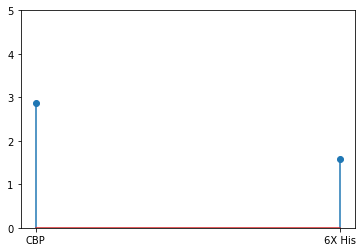

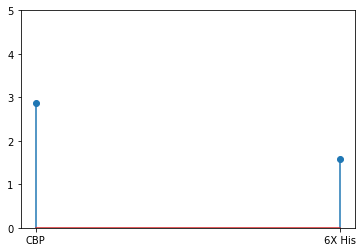

In [148]:
files = [{'Protein0': '/content/PDBs/Protein0_9d99d_unrelaxed_rank_1_model_3.pdb'}, {'Protein0_CBP': '/content/PDBs/Protein0_CBP_f392e_unrelaxed_rank_1_model_5.pdb', 'Protein0_6X His': '/content/PDBs/Protein0_6XHis_89f0d_unrelaxed_rank_1_model_1.pdb'}]

native_dict = files[0]
variant_dict = files[1]

obtain_RMSD(native_dict,variant_dict)